# Calibrazione della camera
La calibrazione della camera è un processo fondamentale che viene eseguito nei sistemi di visione di misura industriale basati su matrici di pixel, come ad esempio le telecamere CCD o CMOS, in questo caso verrà utilizzato un sensore CMOS da 24MP. Questa procedura viene effettuata al fine di garantire la massima accuratezza e precisione nelle misurazioni geometriche degli oggetti in esame.

In particolare, la calibrazione della camera si basa sulla determinazione dei parametri intrinseci e estrinseci che caratterizzano la geometria della telecamera e la sua posizione nello spazio rispetto all'oggetto da misurare. I parametri intrinseci includono:

* La lunghezza focale, che determina il rapporto tra la distanza dell'oggetto dalla lente della telecamera e la sua dimensione apparente sull'immagine;
* La distorsione geometrica, che causa una deformazione delle immagini a causa dell'effetto di curvatura dei raggi luminosi sulla superficie della matrice dei pixel.

I parametri estrinseci, invece, riguardano la posizione e l'orientamento della telecamera nello spazio, che vengono descritti tramite una matrice di rotazione e un vettore di traslazione.

La calibrazione della camera viene eseguita mediante l'utilizzo di un opportuno pattern geometrico, costituito da punti distinti disposti in maniera nota nello spazio, chiamato master di taratura. Tramite la misura delle coordinate dei punti sul master dei pixel e le loro corrispondenti posizioni reali nello spazio, è possibile ricavare i parametri intrinseci ed estrinseci della telecamera tramite un'opportuna procedura di ottimizzazione.

Questo processo prevede l'acquisizione di un'immagine di un punto noto e l'ottenimento delle sue coordinate Xsg, Ysg, Zsg proiettate nel sistema Is, Js. Tuttavia, ci sono 11 incognite e solo 2 equazioni, con ogni punto che ha solo 2 coordinate. Per risolvere questo sistema, sono necessari almeno 6 punti diversi con coordinate Zsg diverse, il che si traduce in un totale di 12 equazioni.

Il recupero dei punti noti è basato sul master di taratura. Per l'asse X, vengono identificati i marcatori più grandi e si calcola la loro distanza reciproca per poter determinare i centri più distanti che formano l'asse x. Per l'asse Y, i centri meno distanti vengono utilizzati per formare l'asse y. Le coordinate globali sono determinate in base al centro del sistema globale nel centro del master di taratura.

Input del processo di calibrazione che dovrà inserire l'utente:
- nome e path dell'immagine
- soglia alta e bassa della correzzione del contrasto
- soglia binarizzazione
- numero target rige e colonne
- distanza dei centri del master di taratura in mm

Distanza tra camera e piano : 530 mm

Dimensioni: (4000, 5820, 3)


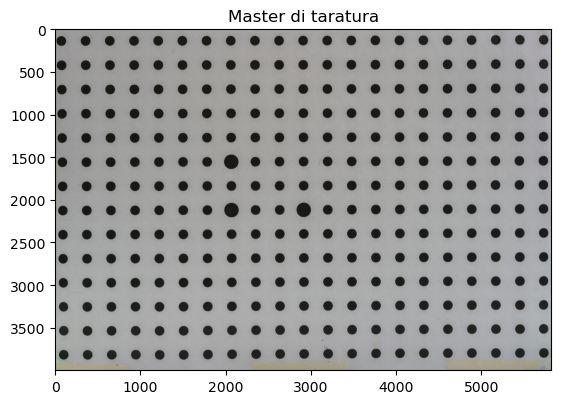

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from os import listdir, path
import os
import panel as pn


IMGDIR = 'img/'
IMGNAME = 'Calibrazione_camera_vera.jpg'
#Soglia alta e bassa del filtro di contrasto
thLow = 50
thHigh = 170
#Soglia per la binarizzazione
thLowBin = 20
thHighBin = 255
#numero di target sulle righe e sulle colonne
n_targets = 14
m_targets = 21

img = cv.imread(os.path.join( IMGDIR, IMGNAME), cv.IMREAD_COLOR )
assert img is not None, "ERRORE: Immagine non trovata!"

h, w, _ = img.shape
print( f"Dimensioni: {img.shape}" )

rgb = cv.cvtColor( img, cv.COLOR_BGR2RGB ) 
gray = cv.cvtColor( img, cv.COLOR_BGR2GRAY ) 

plt.imshow(rgb)
plt.title("Master di taratura")
plt.show()

# Contrasto e binarizzazione
Regolando il contrasto, è possibile migliorare la visibilità e la distinguibilità dei marcatori utilizzati per la calibrazione, facilitandone l'identificazione e la localizzazione accurata. Ciò si traduce in misurazioni più precise e un numero inferiore di errori durante il processo di calibrazione.

La binarizzazione, invece, semplifica l'immagine convertendola in un formato binario con solo due colori o livelli di grigio. Ciò può aiutare ad eliminare il rumore di fondo e altre caratteristiche irrilevanti, consentendo una focalizzazione più chiara sui marcatori. Riducendo la complessità dell'immagine, la binarizzazione può anche accelerare i tempi di elaborazione richiesti per la calibrazione, rendendo il processo complessivamente più efficiente.

(-0.5, 5819.5, 3999.5, -0.5)

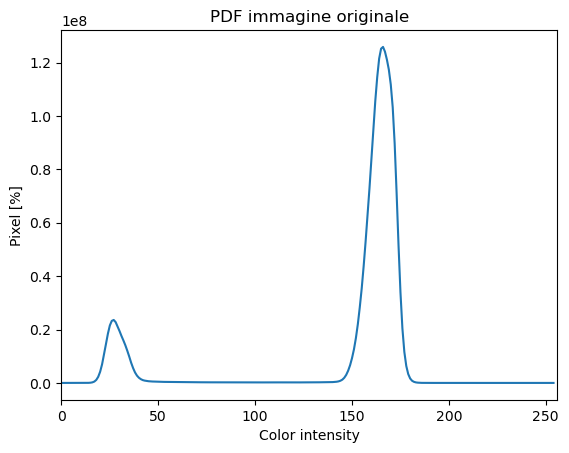

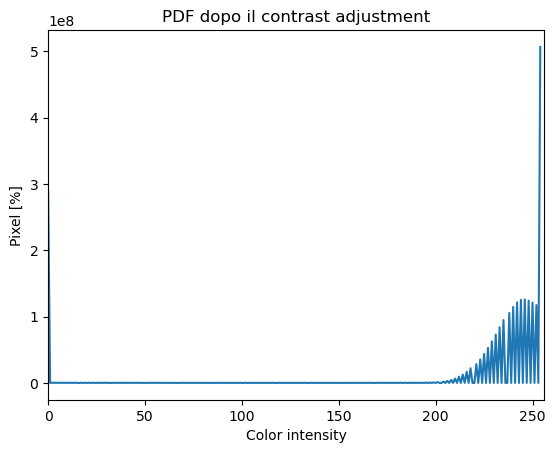

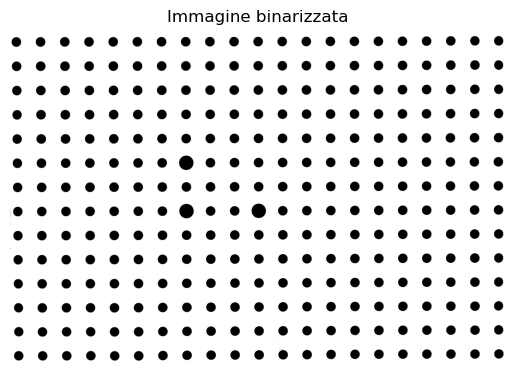

In [3]:
pdf = np.histogram( gray, bins=range(256) )[0]/1*100
#Plot histogram pdf
fig, ax = plt.subplots()
ax.plot( pdf )
ax.set_title( "PDF immagine originale" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

#eseguo un contrast adjustment, quindi rendo più netta la distinzione tra i singoli bit di sfumature di colore
def contrastAdjust( px, th_l, th_h ):
    if px < th_l:
        return 0
    if px >= th_h:
        return 255
    else:
        return 255*(px - th_l)/(th_h - th_l)

imgContrastAdjust = np.frompyfunc( lambda x: contrastAdjust(x, thLow, thHigh), 1, 1)
imgCA = imgContrastAdjust(gray).astype('uint8')

pdf2 = np.histogram( imgCA, bins=range(256) )[0]/1*100
fig, ax = plt.subplots()
ax.plot( pdf2 )
ax.set_title( "PDF dopo il contrast adjustment" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

#eseguo la binarizzazione dell'immagine, tramite opencv, ma comunque prendendo come neri i pixel a 0 e bianci a 255, in base alle regole della binarizzazione
ret2, imgBIN = cv.threshold( imgCA, thLowBin, thHighBin, cv.THRESH_BINARY )
fig, ax = plt.subplots()
ax.imshow( imgBIN, cmap='gray' )
ax.set_title( "Immagine binarizzata" )
ax.axis('off')

# Ricerca dei target circolari
La funzione `HoughCircles` è una funzione della libreria OpenCV che viene utilizzata per rilevare i cerchi in un'immagine. Utilizza la trasformata di Hough per i cerchi, trovando sia il **centro che il loro raggio.**

Ecco come si usa:

```python
circles = cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]])
```

Parametri:

- `image`: L'immagine in cui cercare i cerchi. Deve essere una immagine in scala di grigi.
- `method`: Il metodo di rilevamento da utilizzare. Attualmente, l'unico metodo implementato è `cv2.HOUGH_GRADIENT`.
- `dp`: Il rapporto inverso della risoluzione dell'accumulatore rispetto alla risoluzione dell'immagine.
- `minDist`: La distanza minima tra i centri dei cerchi rilevati.
- `circles` (opzionale): Un output vettore che memorizza i cerchi rilevati.
- `param1` (opzionale): Il primo parametro specifico del metodo. Nel caso di `cv2.HOUGH_GRADIENT`, è il limite superiore del due passaggi di soglia applicato nell'algoritmo di rilevamento dei bordi interno.
- `param2` (opzionale): Il secondo parametro specifico del metodo. Nel caso di `cv2.HOUGH_GRADIENT`, è il soglia dell'accumulatore per i centri dei cerchi. Più piccolo è, più cerchi falsi possono essere rilevati. I cerchi, corrispondenti ai maggiori accumulatore, saranno restituiti per primi.
- `minRadius` (opzionale): Il raggio minimo dei cerchi da rilevare.
- `maxRadius` (opzionale): Il raggio massimo dei cerchi da rilevare.

La funzione restituisce `circles`, che è un vettore che contiene i cerchi rilevati. Ogni cerchio è rappresentato come un vettore a 3 elementi `(x_center, y_center, radius)`.

Sono stati torvati 294 cerchi su 294.


(-0.5, 5819.5, 3999.5, -0.5)

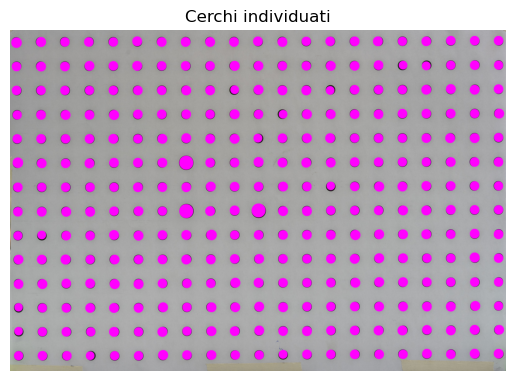

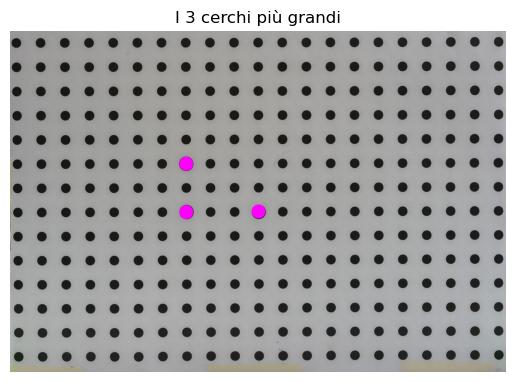

In [4]:
sz = h*w
minDistance=113
minRadius=16 #raggio minimo
maxRadius=86 #raggio massimo

#################################################################################
# HoughCircles, funzione di opencv che permette di trovare cerchi in un'immagine#
#################################################################################

circles = cv.HoughCircles( imgBIN, cv.HOUGH_GRADIENT, 8, minDist=minDistance, minRadius=minRadius, maxRadius=maxRadius, param1=140, param2=90 )
cdst = rgb.copy()
if circles is not None:
    print( f"Sono stati torvati {len(circles[0, :])} cerchi su {n_targets*m_targets}.")
    circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    center = (i[0], i[1])
    #cv.circle(cdst, center, 1, (0, 100, 100), -1)
    radius = i[2]
    cv.circle(cdst, center, radius, (255, 0, 255), -1)
fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title( "Cerchi individuati" )
ax.axis('off')
circles[:,:,2]

################################################################################
#Ordinamento dei cerchi in base al raggio e selezione dei 3 cerchi più grandi#
################################################################################

#ordinare i cerchi in base al loro raggio
circles2=circles[0,:,:]
circles2=circles2[circles2[:,2].argsort()]
#salvo i 3 cerchi con raggio piu grande
circles3=circles2[-3:,:]
#stampo l'immagine con i 3 cerchi piu grandi
cdst3 = rgb.copy()
for i in circles3:
    center = (i[0], i[1])
    radius = i[2]
    cv.circle(cdst3, center, radius, (255, 0, 255), -1)
fig, ax = plt.subplots()
ax.imshow( cdst3 )
ax.set_title( "I 3 cerchi più grandi" )
ax.axis('off')


# Ricerca dei target circolari

L'uso di `findCirclesGrid` può semplificare notevolmente il processo di calibrazione della telecamera, poiché automatizza la localizzazione dei marcatori di riferimento necessari per il calcolo dei parametri di proiezione. In questo modo, è possibile ridurre al minimo gli errori manuali e aumentare la precisione e l'efficienza del processo di calibrazione.
La funzione `findCirclesGrid` è una funzione della libreria OpenCV utilizzata per identificare i pattern di cerchi in un'immagine.

Ecco come si usa:

```python
retval, centers = cv2.findCirclesGrid(image, patternSize[, centers[, flags[, blobDetector]]])
```

Parametri:

- `image`: L'immagine in cui cercare il pattern di cerchi.
- `patternSize`: Il numero di cerchi per riga e colonna (es. (rows, columns)).
- `centers` (opzionale): Questo è un output che restituisce le coordinate dei centri dei cerchi trovati.
- `flags` (opzionale): Questi parametri modificano il modo in cui la funzione cerca i cerchi. Alcuni esempi includono `cv2.CALIB_CB_SYMMETRIC_GRID`, `cv2.CALIB_CB_ASYMMETRIC_GRID`, e `cv2.CALIB_CB_CLUSTERING`.
- `blobDetector` (opzionale): Un oggetto `cv2.SimpleBlobDetector` che è utilizzato per rilevare i cerchi.

La funzione restituisce un valore booleano `retval` che indica se è stato trovato un pattern valido, e `centers` che è un array di coordinate dei centri dei cerchi trovati.


Sono stati torvati 294 cerchi su 294.


Text(0.5, 1.0, 'Cerchi individuati')

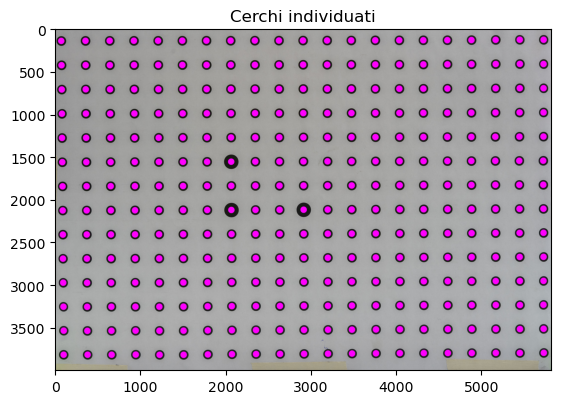

In [5]:
pattern = (m_targets,n_targets)
# è utile ridurre le dimensioni dell'immagine, questo codice calcola le nuove dimensioni mantenendo l'aspetto originale
scale_percent = 40  # percentuale di scala originale
width = int(imgBIN.shape[1] * scale_percent / 100)
height = int(imgBIN.shape[0] * scale_percent / 100)
dim = (width, height)

################################################################################
#Ricerca dei cerchi con la funzione findCirclesGrid di opencv, che permette di trovare cerchi in un'immagine#
################################################################################

# Ridimensiona l'immagine
resized = cv.resize(imgBIN, dim, interpolation = cv.INTER_AREA)
ret, centers = cv.findCirclesGrid( resized, pattern, flags=cv.CALIB_CB_SYMMETRIC_GRID )
scale_ratio = 1 / (scale_percent / 100)
# Ridimensiona le coordinate dei centri dei cerchi
centers = centers * scale_ratio

if centers is not None:
    print( f"Sono stati torvati {len(centers)} cerchi su {n_targets*m_targets}.")
else:
    print( "Nessun cerchio trovato!" )
cdst = rgb.copy()
if centers is not None: 
    for center in centers:
        cv.circle( cdst, center[0].astype('int16'), int(w/150), (255,0,255), -1 )

fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title( "Cerchi individuati" )

# Trovo i 3 marker grandi
Le coordinate dei centri generati dal metodo `findCirclesGrid` sono più accurate rispetto a quelle generate da `HoughCircles` che però riesce anche a riconoscere il raggio dei cerchi.
Dovremo allora capire quali coordinate corrispondono tra i due metodi in modo da trovare `0,y,x` nella matrice generata da `findCirclesGrid`.

Per farlo dovremo anche calolare la distanza reciproca tra i diversi marker grandi.

array([[ 2916,  2116,  1013],
       [ 2068,  1556, 25582],
       [ 2068,  2124, 65256]], dtype=uint16)

array([[2069.9395, 2122.8447]], dtype=float32)

array([ 2068,  2124, 65256], dtype=uint16)

155

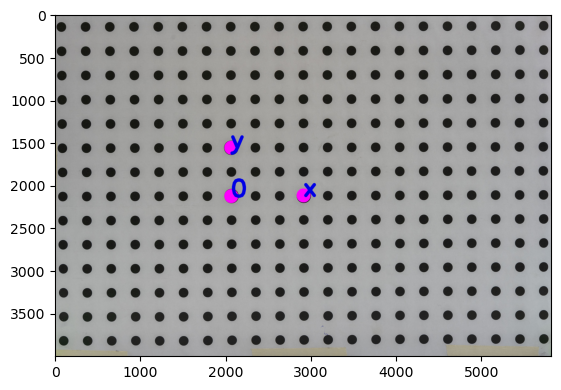

In [6]:
#Calcolo della distanza reciproca tra i 3 cerchi più grandi
for i in circles3:
    distanza=0
    for j in circles3:
        #solo se j e i sono diversi
        if i[0]!=j[0] or i[1]!=j[1]:
            #calcola la distanza tra i due cerchi
            distanza = np.linalg.norm(np.array([i[0], i[1]]) - np.array([j[0], j[1]])) + distanza
    #salva distanza in circle3 come terzo elemento
    i[2]=distanza

#ordina i cerchi in base alla distanza
circles3=circles3[circles3[:,2].argsort()]

arr = []
arr.append("x")
arr.append("y")
arr.append("0")
indice=0

for i in circles3:
    center = (i[0], i[1])
    #stampa la coordinata dell'asse rappresentato dal punto
    cv.putText(cdst3, str(arr[indice]), center, cv.FONT_HERSHEY_SIMPLEX, int(w/600), (0, 0, 230), int(w/150), cv.LINE_AA)
    indice=indice+1

fig, ax = plt.subplots()
ax.imshow( cdst3 )
display(circles3)

#Trovo l'indice del centroide
bestDistance=1000
k=0
temp=0
for i in centers:
    #calcola la distanza tra i due cerchi
    temp=temp+1
    distanza=np.sqrt((i[0][0]-circles3[2][0])**2+(i[0][1]-circles3[2][1])**2)
    if bestDistance>distanza:
        k=temp
        bestDistance=distanza
        bestCenter=i

# Centro del sistema
mainCircle = np.array( bestCenter) 

# Indice del centro
iCenter = k

display(mainCircle)
display(circles3[2])
display(iCenter)

# Camera Calibration 

La funzione `calibrateCamera` è una funzione della libreria OpenCV utilizzata per calibrare la camera. Questa funzione stima i parametri intrinseci e extrinseci della camera.

Ecco come si usa:

```python
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]])
```

Parametri:

- `objectPoints`: Un array di punti nell'oggetto di riferimento. Questo è solitamente un array di punti 3D reali che corrispondono ai punti nell'immagine.
- `imagePoints`: Un array di punti corrispondenti nell'immagine. Questi sono solitamente punti 2D nell'immagine che corrispondono ai punti dell'oggetto.
- `imageSize`: La dimensione dell'immagine utilizzata per la calibrazione.
- `cameraMatrix` (opzionale): Una matrice 3x3 che rappresenta i parametri intrinseci della camera.
- `distCoeffs` (opzionale): I coefficienti di distorsione della camera.
- `rvecs` e `tvecs` (opzionali): I vettori di rotazione e traslazione tra i sistemi di coordinate dell'oggetto e dell'immagine.
- `flags` (opzionale): Questi parametri modificano il modo in cui la funzione calibra la camera.
- `criteria` (opzionale): I criteri per l'ottimizzazione dell'algoritmo di calibrazione.

La funzione restituisce:

- `retval`: Un singolo valore di errore di riproiezione.
- `cameraMatrix`: La matrice della camera con i parametri intrinseci ottimizzati.
- `distCoeffs`: I coefficienti di distorsione ottimizzati.
- `rvecs`: I vettori di rotazione per ogni combinazione di punti dell'oggetto e dell'immagine.
- `tvecs`: I vettori di traslazione per ogni combinazione di punti dell'oggetto e dell'immagine.

Camera Matrix:
 [[2.19166397e+04 0.00000000e+00 2.50583627e+03]
 [0.00000000e+00 2.19190885e+04 2.97023505e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Coefficienti di distorsione:
 [[-1.10308821e-01  5.30242781e+00 -3.86194530e-03 -2.34715815e-03
  -5.56060391e+01]] 

New Camera Matrix:
 [[2.18892891e+04 0.00000000e+00 2.50310606e+03]
 [0.00000000e+00 2.19089082e+04 2.96615923e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Percentuale area foto scartata: 0.69


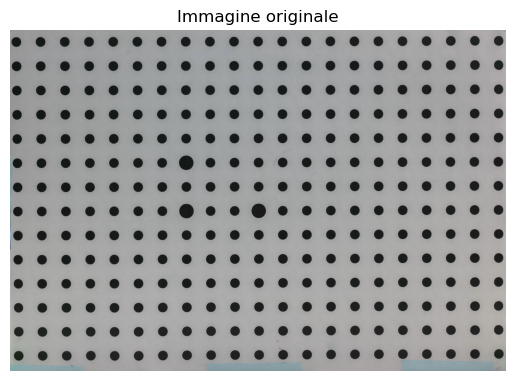

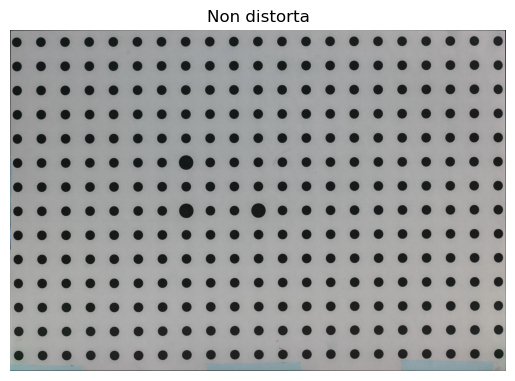

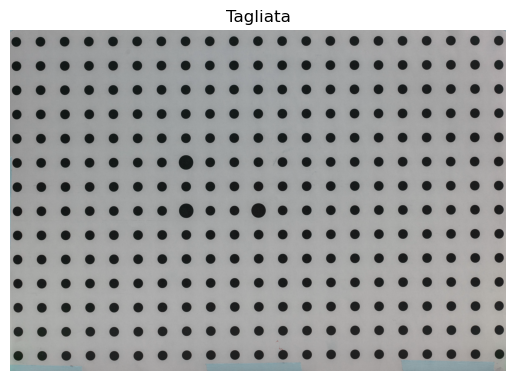

In [7]:
Zsg = 0
deltaX = 20 #mm
deltaY = 20 #mm

################################################################################
# Coordinate oggetto rappresentate tramite un array tridimensionale, 
# centrate nel marker principale e distanziate 20mm (reale distanza tra marker)
################################################################################

objpts = np.zeros((m_targets*n_targets,3), np.float32)
objpts[:,:2] = np.mgrid[0:m_targets,0:n_targets].T.reshape(-1,2)   
objpts[:] = objpts[:] - objpts[iCenter,:]   
objpts[:,0] = objpts[:,0]*deltaX
objpts[:,1] = -1*objpts[:,1]*deltaY
objpts[:,2] = Zsg


#####################################################################
# Coordinate immagine rappresentate tramite un array bidimensionale
# ed estratte da quelle trovate con findCirclesGrid
#####################################################################

objpoints = [] 
imgpoints = [] 
objpoints.append(objpts)
imgpoints.append(centers)
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)
newcameramtx, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w,h), 1, (w,h))

print( f"Camera Matrix:\n {cameraMatrix} \n")
print( f"Coefficienti di distorsione:\n {distCoeffs} \n")
print( f"New Camera Matrix:\n {newcameramtx}")



#################################################################################################
# Image cropping, per eliminare eventuali errori e zone non utili alla calibrazione
#################################################################################################

img = cv.imread(os.path.join( IMGDIR, IMGNAME), cv.IMREAD_COLOR)
hold, wold, _ = img.shape
undistorted = cv.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)
x, y, w, h = roi
img_roi = undistorted[y:y+h, x:x+w]

fig, ax = plt.subplots()
ax.imshow( img, cmap='gray' )
ax.axis('off')
ax.set_title( "Immagine originale" )

fig, ax = plt.subplots()
ax.imshow( undistorted )
ax.axis('off')
ax.set_title( "Non distorta" )

fig, ax = plt.subplots()
ax.imshow( img_roi )
ax.axis('off')
ax.set_title( "Tagliata" )

percentage = 100 - ((((w - x) * (h - y)) / (hold * wold)) * 100)
rounded_percentage = round(percentage, 2)
print("\nPercentuale area foto scartata: {}".format(rounded_percentage))

image = img_roi.copy()
image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)


# Devo ritorvare tutti i punti dell'immagine non distorta
1. Contrasto
2. Binarizzazione
3. Find circleGrid

Sono stati torvati 294 cerchi su 294.


(-0.5, 5805.5, 3990.5, -0.5)

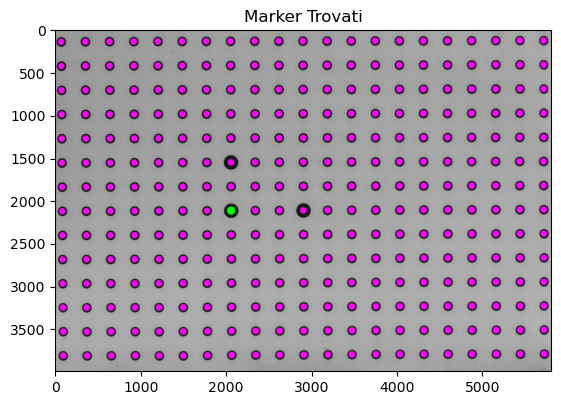

In [8]:
################################################################################
# Contrast adjustment, per rendere più netta la distinzione tra i singoli bit di sfumature di colore
################################################################################
imgContrastAdjust = np.frompyfunc( lambda x: contrastAdjust(x, thLow, thHigh), 1, 1)
imgCA = imgContrastAdjust(image).astype('uint8')

################################################################################
#eseguo la binarizzazione dell'immagine
################################################################################

ret2, imgBIN = cv.threshold( imgCA, thLowBin, thHighBin, cv.THRESH_BINARY )


pattern = (m_targets,n_targets)
# è utile ridurre le dimensioni dell'immagine, questo codice calcola le nuove dimensioni mantenendo l'aspetto originale
scale_percent = 40  # percentuale di scala originale
width = int(imgBIN.shape[1] * scale_percent / 100)
height = int(imgBIN.shape[0] * scale_percent / 100)
dim = (width, height)

# Ridimensiona l'immagine
resized = cv.resize(imgBIN, dim, interpolation = cv.INTER_AREA)
ret, centers = cv.findCirclesGrid( resized, pattern, flags=cv.CALIB_CB_SYMMETRIC_GRID )
scale_ratio = 1 / (scale_percent / 100)
# Ridimensiona le coordinate dei centri dei cerchi
centers = centers * scale_ratio

if centers is not None:
    print( f"Sono stati torvati {len(centers)} cerchi su {m_targets*n_targets}.")
else:
    print( "Nessun cerchio trovato!" )  

iCenter = iCenter-1
mainCircle = centers[iCenter]
print(mainCircle[0])
cdst = cv.cvtColor( image, cv.COLOR_GRAY2RGB )
if centers is not None: 
    for center in centers:
        cv.circle( cdst, center[0].astype('int16'), int(w/150), (255,0,255), -1 )

cv.circle(cdst, np.uint16(mainCircle[0]), int(w/120), (0, 255, 0), -1)

fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title("Marker Trovati")
ax.axis('on')

A partire dai **punti oggetto 3D** e dai **punti immagine 2D** risolvo il sistema del tipo:
$$Q *m = d$$

Dove m è detto **vettore dei coefficienti** e contine i parametri intrinseci ed estrinseci della telecamera

N.B. per ottenere m non verranno utilizzate tutte le **coordinate immagine e oggetto**, ma questi set di punti verrano divisi in modo omogeneo in due: uno dedicato alla **calibrazione della telecamera** e uno alla realizzazione dei **test di verifica** dei risultati ottenuti

In [9]:
################################################################################
#Cerco il vettore m dei coefficienti della matrice di calibrazione
################################################################################


Zsg = 0
deltaX = 20
deltaY = 20

################################################################################
# coordinate oggetto 3D  
################################################################################

objpts = np.zeros((m_targets*n_targets,3), np.float32)
objpts[:,:2] = np.mgrid[0:m_targets,0:n_targets].T.reshape(-1,2)
objpts[:] = objpts[:] - objpts[iCenter,:]
objpts[:,0] = objpts[:,0]*deltaX
objpts[:,1] = -1*objpts[:,1]*deltaY
objpts[:,2] = Zsg

################################################################################
# coordinate immagine 2D  
################################################################################


imgpts = centers

objpoints = [] 
imgpoints = [] 
objpoints.append( objpts )
imgpoints.append( centers )

##############################################################################
# Divisione dei punti in due array: uno per la calibrazione e uno per i test
##############################################################################

imgpts_cal = [] 
objpts_cal = [] 
imgpts_test = [] 
objpts_test = []         
j=0
l=1
for i in range(int(len(imgpts)/2)):
    imgpts_cal.append(imgpts[j])
    objpts_cal.append(objpts[j])
    imgpts_test.append(imgpts[l])
    objpts_test.append(objpts[l])
    j+=2
    l+=2
imgpts_cal = np.array(imgpts_cal)
objpts_cal = np.array(objpts_cal)

#########################################################################################################
# Calcolo del vettore m che contiene sia i parametri intrinseci che estrinseci della camera
#########################################################################################################

Q = []
d = []
for i in range( objpts_cal.shape[0] ):
    op = objpts_cal[i]   
    ip = imgpts_cal[i][0]

    i_s = ip[1]     
    j_s = ip[0] 

    Q.append(np.concatenate( [op, [1,0,0,0,0], -1*op*i_s] ))
    Q.append(np.concatenate( [[0,0,0,0], op, [1], -1*op*j_s]))
    d.append( i_s )
    d.append( j_s )

Q=np.array(Q)
d=np.array(d)

m = np.dot( np.linalg.pinv( Q ), d )
print( f"Vettore m:\n {m} \n" )


gamma2 = m[8]**2 + m[9]**2 + m[10]**2
tz = np.sqrt(1/gamma2)
P = np.reshape( np.concatenate( [m,[1]] )*tz, (3,4) )
print( f"Matrice P:\n {P} \n" )

##################################################################################################################
# Calcolo dei restanti parametri della matrice di calibrazione K
##################################################################################################################

r31 = P[2,0] 
r32 = P[2,1]
r33 = P[2,2]

i_0 = P[0][0]*r31+P[0][1]*r32+P[0][2]*r33
j_0 = P[1][0]*r31+P[1][1]*r32+P[1][2]*r33
f_x = np.sqrt(P[0,0]**2+P[0,1]**2+P[0,2]**2-i_0**2)
f_y = np.sqrt(P[1,0]**2+P[1,1]**2+P[1,2]**2-j_0**2)

R=np.zeros([3,3])
R[0,0]=(P[0,0]-i_0*P[2,0])/f_x
R[0,1]=(P[0,1]-i_0*P[2,1])/f_x
R[0,2]=(P[0,2]-i_0*P[2,2])/f_x
R[1,0]=(P[1,0]-j_0*P[2,0])/f_y
R[1,1]=(P[1,1]-j_0*P[2,1])/f_y
R[1,2]=(P[1,2]-j_0*P[2,2])/f_y
R[2,0]=P[2,0]
R[2,1]=P[2,1]
R[2,2]=P[2,2]

t_z=P[2][3]
t_x=(P[0,3]-i_0*t_z)/f_x
t_y=(P[1,3]-j_0*t_z)/f_y
     

Vettore m:
 [-3.39350770e-02 -1.41508634e+01 -1.37943454e-08  2.11305467e+03
  1.41246883e+01 -8.38573262e-02  4.54722405e-13  2.06119373e+03
  7.65435534e-06 -1.19305674e-05  0.00000000e+00] 

Matrice P:
 [[-2.39402702e+03 -9.98304771e+05 -9.73153399e-04  1.49070237e+08]
 [ 9.96458189e+05 -5.91590539e+03  3.20794240e-08  1.45411590e+08]
 [ 5.39993869e-01 -8.41668950e-01  0.00000000e+00  7.05472694e+04]] 



## $Verifica$ $Calibrazione$

La **verifica dei parametri** trovati durante la calibrazione avviene in 2 sensi:
- Come i punti oggetto 3D vengono mappati nelle coordinate immagine 2D e si calcolano valore medio degli **scarti** e **deviazione standard**
- Come i punti immagine 2D vengono mappati nelle coordinate oggetto 3D e si calcolano valore medio degli **scarti** e **deviazione standard**

Verifica da coordinate oggetto a coordinate immagine
Valore medio degli scarti i= 0.7965035185699305
Valore medio degli scarti j= 0.7081574001642107
Deviazione standard i= 0.7885986093852184
Deviazione standard j= 0.5591897627478795

Verifica da coordinate immagine a coordinate oggetto
Valore medio degli scarti i= 0.05653491467776623
Valore medio degli scarti j= 0.050126077140789024
Deviazione standard x= 0.05611396729399067
Deviazione standard y= 0.039654930453086615


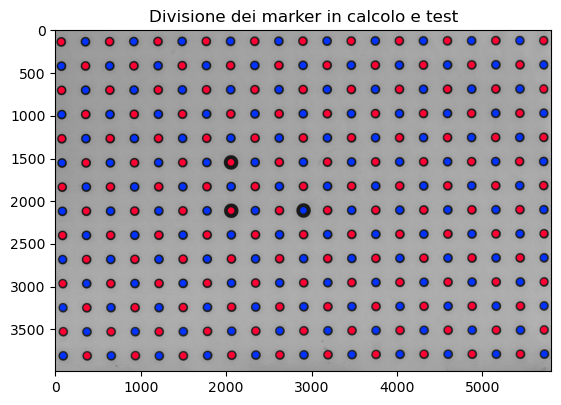

In [10]:
#######################################################
# Test 1: Da coordinate oggetto a coordinate immagine
# si crea un sistemsa di coordinate omogenee, per poi normalizzare IJK dividendo per la terza coordinata IJ, poi trasformando in coordinate immagine, 
# il tutto per calcolare lo scarto tra le coordinate oggetto e le coordinate immagine
#######################################################

punti_immagine_verifica = []
scarto = []

for i in range(len(objpts_test)):
    IJK = np.dot(P,np.append(objpts_test[i],1)) 
    IJ = (IJK/IJK[2])[0:2] 
    scarto.append(abs(IJ[::-1]-imgpts_test[i]))
    
scarto = np.array(scarto)

Ei = scarto[:,0,0].mean()
Ej = scarto[:,0,1].mean()
stdi = scarto[:,0,0].std()
stdj = scarto[:,0,1].std()
print("Verifica da coordinate oggetto a coordinate immagine")
print( f"Valore medio degli scarti i= {Ei}" )
print( f"Valore medio degli scarti j= {Ej}" )
print( f"Deviazione standard i= {stdi}" )
print( f"Deviazione standard j= {stdj}" )


#######################################################
# Test 2: Da coordinate immagine a coordinate oggetto
# si crea un sistemsa di coordinate omogenee, per poi normalizzare IJK dividendo per la terza coordinata IJ, poi trasformando in coordinate oggetto,
# il tutto per calcolare la distanza tra le coordinate immagine e le coordinate oggetto, e quindi lo scarto tra le coordinate immagine e le coordinate oggetto
#######################################################

objpts_test = np.array(objpts_test)
scarto_x = []
scarto_y = []
for i in range(len(imgpts_test)):

    i_pts=imgpts_test[i][0][1]
    j_pts=imgpts_test[i][0][0]
    A=np.zeros([2,2])
    b=np.zeros([2,1])
    A[0,0] = m[0]-m[8]*i_pts
    A[0,1] = m[1]-m[9]*i_pts
    A[1,0] = m[4]-m[8]*j_pts
    A[1,1] = m[5]-m[9]*j_pts
    
    b[0,0] = i_pts- (m[2]-m[10]*i_pts)*Zsg - m[3]
    b[1,0] = j_pts- (m[6]-m[10]*j_pts)*Zsg - m[7]

    XY=np.linalg.solve(A,b)
    scarto_x.append(abs(XY[0]-objpts_test[i][0]))
    scarto_y.append(abs(XY[1]-objpts_test[i][1]))
    
scarto_x = np.array(scarto_x)
scarto_y = np.array(scarto_y)

Ex = scarto_x.mean()
Ey = scarto_y.mean()
stdx = scarto_x.std()
stdy = scarto_y.std()
print("\nVerifica da coordinate immagine a coordinate oggetto")
print( f"Valore medio degli scarti i= {Ex}" )
print( f"Valore medio degli scarti j= {Ey}" )
print( f"Deviazione standard x= {stdx}" )
print( f"Deviazione standard y= {stdy}" )


cdst = cv.cvtColor( image, cv.COLOR_GRAY2RGB )
for center in imgpts_cal:
    cv.circle( cdst, center[0].astype('int16'), int(w/150), (255,0,50), -1 )
for center in imgpts_test:
    cv.circle( cdst, center[0].astype('int16'), int(w/150), (0,50,255), -1 )


plt.imshow( cdst)
plt.title("Divisione dei marker in calcolo e test")
plt.show()

# $Calibrazione$ $lama$ $di$ $luce$

Importiamo, una per volta, le immagini acquisite per la calibrazione della lama di luce e la modifichiamo togliendo la distorsione e facendo il cropping. Successivamente per ogni immagine vengono trovati i baricentri della lama di luce e si memorizzano in 2 array (uno per la calibrazione e uno per i test) alcuni dei baricentri identificati

/Users/eldemaster/Documents/Uni/Sistemi_di_visione_3D/.conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/eldemaster/Documents/Uni/Sistemi_di_visione_3D/.conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


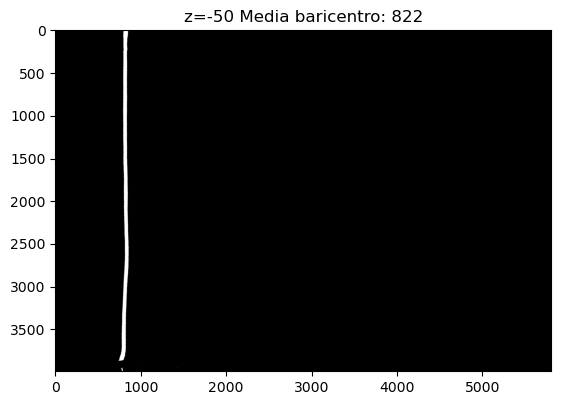

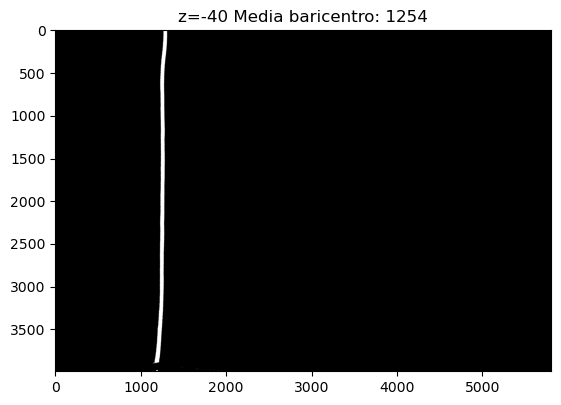

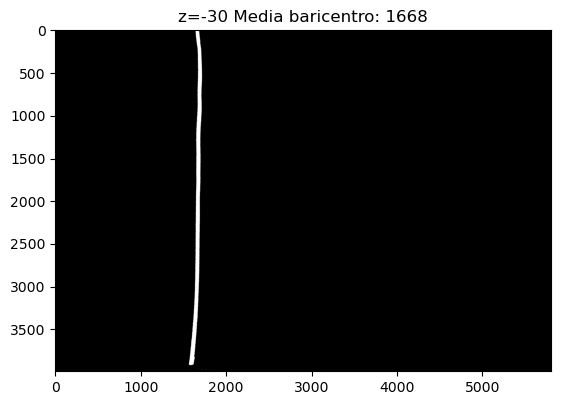

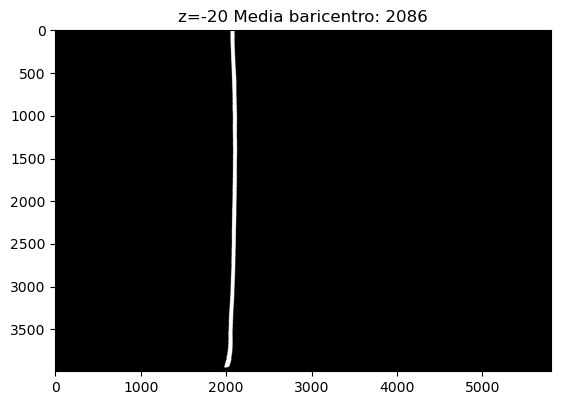

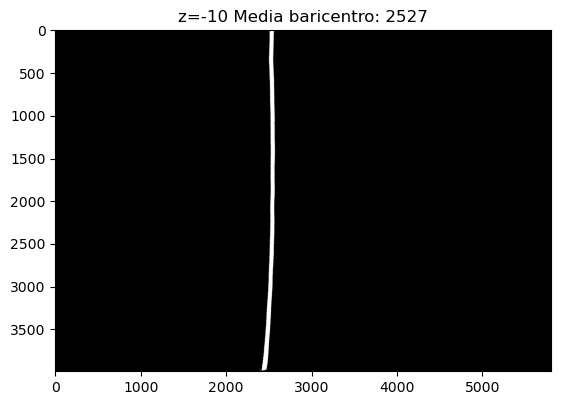

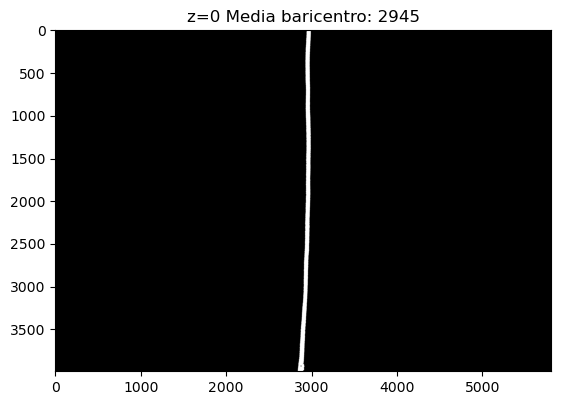

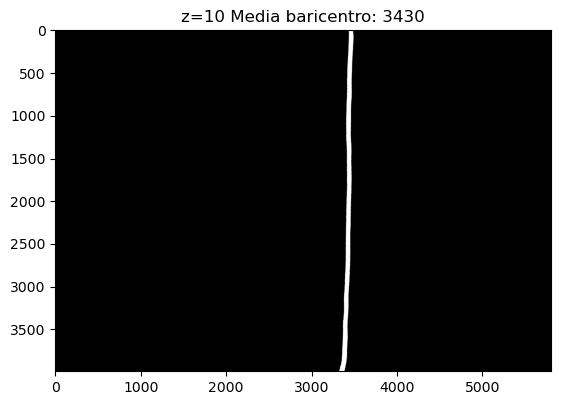

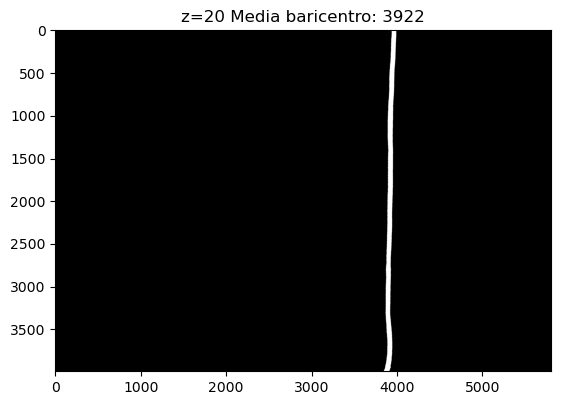

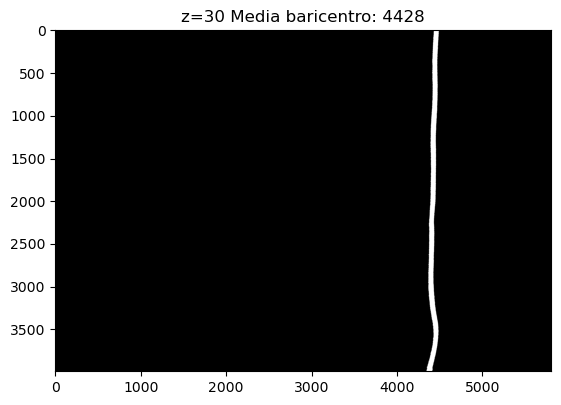

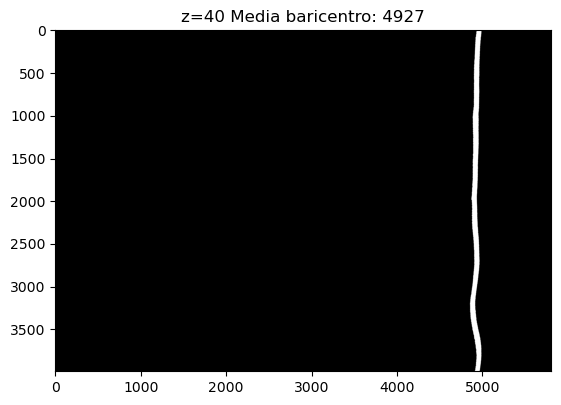

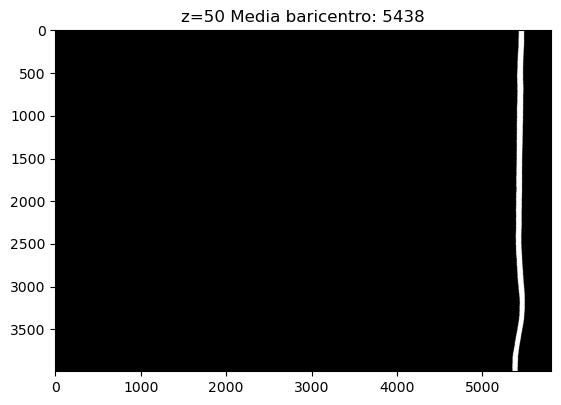

In [11]:
images =[-50,-40,-30,-20,-10,0,10,20,30,40,50]
lama_cal =[]
lama_test =[]
temp_v=[]

soglia_treshold = 30
da_eliminare = 200
counter_punti=0


for element in images:

    img = cv.imread('img/'+'Calibrazione_'+str(element)+'.jpg')
    assert img is not None, "ERRORE: file non trovato!" 
    undistorted = cv.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)
    
    # Crop the image
    x, y, w, h = roi
    img_roi = undistorted[y:y+h, x:x+w]

    b,g,r = cv.split(img_roi)
    rgb = cv.cvtColor( img_roi, cv.COLOR_BGR2RGB ) 

    ret, th = cv.threshold( r, soglia_treshold, 255, cv.THRESH_BINARY )
    altezza_img, larghezza_img = th.shape

    ####################################################
    # Individuazione dei baricentri della lama di luce, essendo che la lama è una linea, si calcola la media dei pixel non nulli
    ####################################################

    baricentri=[]
    for j in range(altezza_img):
        baricentri.append([j,np.nanmean( np.where( th[j,:] != 0 ) )])
    second_elements = [item[1] for item in baricentri]
    temp = np.nanmean(second_elements)
    temp_v.append([temp, element])
    
    plt.imshow(th,cmap='gray')
    plt.title('z='+str(element)+' Media baricentro: '+str(round(temp)))
    plt.show()
    
    ##############################################################################
    # Divisione dei punti in due array: uno per la calibrazione e uno per i test #
    ##############################################################################
        
    baricentri_temp1 = []
    baricentri_temp2 = []

    #for i in range( altezza_img-da_eliminare ):
    for i in range( altezza_img-da_eliminare ):
        if i % 5 == 0:
            baricentri_temp2.append( baricentri[i] )
        else:
            baricentri_temp1.append( baricentri[i] )
    
    lama_test.append( baricentri_temp2 )
    lama_cal.append( baricentri_temp1 )
    
temp_v = np.array(temp_v)
average_diff_z = np.nanmean(np.abs(np.diff(temp_v[:, 1])))
average_diff_pixel = np.nanmean(np.abs(np.diff(temp_v[:, 0])))
sensibilita_setup=average_diff_z/average_diff_pixel

lama_test=np.concatenate(lama_test).reshape(-1,2)

Risolvo il sistema sottostante per trovare le Xsg e Ysg corrispondenti ai baricentri
$$A [X_{sg}, Y_{sg}]^T = b$$

Successivamente risolvo il sistema 
$$A * X_{sg} + B * Y_{sg} + C = Z_{sg}$$
per trovare i **coefficienti del piano** A B C identificato dalla lama di luce




In [12]:
numeroPunti = 0

for i in range( len(lama_cal) ):
    numeroPunti += len( lama_cal[i] )
xy = np.zeros([numeroPunti,3])
z = np.zeros([numeroPunti,1])

cont=0

for i in range(len(lama_cal)):
   
    for j in range(len(lama_cal[i])):
        
        
        ######################
        # si itera u i_s e j_s per estrarne le coordinate
        ######################
        
        i_s = lama_cal[i][j][0]
        j_s = lama_cal[i][j][1]
        
        ######################
        # Si creano due matrici A e b di zeri
        ######################
        
        
        A=np.zeros([2,2])
        b=np.zeros([2,1])

        ######################
        # matematica relativa a popolare le matrici A e b con i valori di i_s e j_s
        ######################
        
        A[0,0] = m[0]-m[8]*i_s
        A[0,1] = m[1]-m[9]*i_s
        A[1,0] = m[4]-m[8]*j_s
        A[1,1] = m[5]-m[9]*j_s
       
        b[0,0] = lama_cal[i][j][0]-(m[2]-m[10]*i_s)*images[i]-m[3]
        b[1,0] = lama_cal[i][j][1]-(m[6]-m[10]*j_s)*images[i]-m[7]


        ######################
        # Risolviamo il sistema lineare di equazioni con x incognita
        ######################
        
        x=np.linalg.solve(A,b)
        

        xy[cont,0]=x[0][0]
        xy[cont,1]=x[1][0]
        xy[cont,2]=1
        z[cont]=images[i]
        cont+=1

        
coeff_piano, res, rank, sing = np.linalg.lstsq( xy, z ,rcond = None)

A=coeff_piano[0][0]
B=coeff_piano[1][0]
C=coeff_piano[2][0]
print("Coefficienti del piano della lama di luce:\n")
print( f"A= {A}\n" )
print( f"B= {B}\n" )
print( f"C= {C}\n" )
print('Media residui')
print(np.mean(np.abs(z-xy.dot(coeff_piano))))


Coefficienti del piano della lama di luce:

A= 0.3056936833168251

B= -0.004207740316164221

C= -21.24724133817585

Media residui
1.1795798495187177


# $Verifica$ $Calibrazione$ $lama$

La **verifica dei parametri** trovati durante la calibrazione della lama di luce consiste nel ricomporre le coordinate 3D dei punti nel modo reale a partire dalle corrispondenti coordinate 2D (rappresentate dai baricentri della lama di luce).

A questo punto si verifica che la coordinata Zsg vari di 5mm per ognuna delle immagini considerate e se ne misura **errore medio** e **deviazione standard**

In [13]:
z = []
y = []
x = []

for element in lama_test:
    
    i_s = element[0]
    j_s = element[1]

    H=np.zeros([3,3])
    b=np.zeros([3,1])

    H[0,0] = m[0]-m[8]*i_s
    H[0,1] = m[1]-m[9]*i_s
    H[0,2] = m[2]-m[10]*i_s

    H[1,0] = m[4]-m[8]*j_s
    H[1,1] = m[5]-m[9]*j_s
    H[1,2] = m[6]-m[10]*j_s

    H[2,0] = A
    H[2,1] = B
    H[2,2] = -1     

    b[0,0] = i_s-m[3]
    b[1,0] = j_s-m[7]
    b[2,0] = -C
            
    risultati = np.linalg.solve(H,b)

    x.append(risultati[0])
    y.append(risultati[1])
    z.append(risultati[2])
    
num_immagini=11
distanza_immagini = 10#mm
errore=[]

for i in range(num_immagini):
    for j in range( int(len(z)/num_immagini) ):
        errore.append(abs(z[(i*int(len(z)/num_immagini)+j)]-images[i]))


errore=np.array(errore)
errore_medio=np.mean(errore)
std=np.std(errore)
formatted_erroreMedio = "{:.2f}".format(errore_medio)
formatted_std = "{:.2f}".format(std)
print( f"Errore medio: {errore_medio} mm" )
print( f"Deviazione Standard: {std} mm" )

Errore medio: 1.1796876426759635 mm
Deviazione Standard: 0.6779099500663393 mm


# $MISURAZIONI$

Introduzione di una **funzione** `estrai_baricentri`. Questa permette, data **un'immagine**, di individuare i baricentri della lama di luce, realizzarne una visualizzazione e restituirne **2 array**: uno per l'oggetto e uno per il piano


Calcoliamo la z media del piano di rifermento, e la z minima relativa all'oggetto, infine calcoliamo la misura come differenza tra z minima dell'oggetto e z del piano.

Passaggi:
- eseguo la rimozione della distrosione dell'immagine, 
- croppo, 
- estraggo i baricentri ( quelli relativi alla lama di luce che impatta il piano ),
- estraggo i baricentri ma che impattano sull'oggetto,
- valuto le dimensioni.

Infine, avendo i coefficienti della lama, la matrice P e la matrice della Camera, risolvo il sistema per trovare  $X_{sg}$, $Y_{sg}$ e $Z_{sg}$


- Carico l'immagine.
- Estraggo i baricentri pixel dall'immagine.
- Creo una nuova immagine con le stesse dimensioni dell'originale, ora aggiungo i baricentri pixel alla nuova immagine.
- Estraggo le coordinate dei pixel baricentro dall'immagine originale.
- Calcolo le coordinate z dei pixel baricentro prendendo la media delle coordinate z dei pixel dell'immagine dei baricentri. 
- Calcolo i valori dell'oggetto.

In [14]:
def estrai_baricetri(immagine):
    
    undistorted_f = cv.undistort(immagine, cameraMatrix, distCoeffs, None, newcameramtx)

    # Crop 
    x, y, w, h = roi
    img_roi_f = undistorted_f[y:y+h, x:x+w]
    rgb_f = cv.cvtColor(img_roi_f,cv.COLOR_BGR2RGB)
    gray_f = cv.cvtColor( rgb_f, cv.COLOR_RGB2GRAY )


    ret, th_f = cv.threshold( gray_f, 30, 255, cv.THRESH_BINARY )
    h, w = th_f.shape

    baricentri=[]
    for j in range(h):
        baricentri.append([j,np.nanmean( np.where( th_f[j,:] != 0 ) )])
        
    baricentri_np = np.array(baricentri)

    bar_zRif = []
    bar_zOgg = []
    nimg= cv.cvtColor(gray_f, cv.COLOR_GRAY2RGB)

    pos_lama_media=np.nanmean(baricentri_np[:,1])

    for i in range(h):
        nimg[i,round(pos_lama_media)]=[143,0,255]
        nimg[i,round(pos_lama_media)-1]=[143,0,255]
        nimg[i,round(pos_lama_media)+1]=[143,0,255]
        if np.isnan(baricentri_np[i,1])==False:
            indice = int(baricentri_np[i,1])
            if indice>pos_lama_media:
                nimg[i,indice-1]=[0,255,0]
                nimg[i,indice]=[0,255,0]
                nimg[i,indice+1]=[0,255,0]
                bar_zOgg.append([baricentri_np[i,0], baricentri_np[i,1]])
            elif indice<pos_lama_media:
                nimg[i,indice-1]=[255,0,0]
                nimg[i,indice]=[255,0,0]
                nimg[i,indice+1]=[255,0,0]
                bar_zRif.append([baricentri_np[i,0], baricentri_np[i,1]])

    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.imshow( nimg )
    ax.set_title("Baricentro: " + str(round(pos_lama_media))+'pixel')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_on()

    return bar_zRif, bar_zOgg, h, th_f, baricentri_np, pos_lama_media, w

Introduzione di una **funzione** `estrai_punti_oggetto`. Questa permette di ricavare le **coordinate oggetto** dei punti in una lama a partire dalle sue **coordinate immagine**.

In [15]:
def estrai_punti_oggetto(baric):
    
    z = []  
    y = []  
    x = []  

    for element in baric:
        H = np.zeros([3, 3])
        b = np.zeros([3, 1])

        #######################
        # Calcolo del sistema #
        #######################
        
        # H matrix and b array configuration
        H[0, 0] = m[0] - m[8] * element[0]
        H[0, 1] = m[1] - m[9] * element[0]
        H[0, 2] = m[2] - m[10] * element[0]
        H[1, 0] = m[4] - m[8] * element[1]
        H[1, 1] = m[5] - m[9] * element[1]
        H[1, 2] = m[6] - m[10] * element[1]
        H[2, 0] = A
        H[2, 1] = B
        H[2, 2] = -1

        b[0, 0] = element[0] - m[3]
        b[1, 0] = element[1] - m[7]
        b[2, 0] = -C

        ##########################
        # Risoluzione del sitema #
        ##########################
        
        # Resolution of the system: Hx=b
        risultati = np.linalg.solve(H, b)

        x.append(risultati[0][0])
        y.append(risultati[1][0])
        z.append(risultati[2][0])

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    return x, y, z

# 1- **ASTUCCIO**

#### Misura reale: 65 mm 
#### Piano a -30 mm
<img src="img\Misure_00.jpg" width="400">


z del piano di riferimento: -30.06 mm
z massima dell'oggetto: 34.38 mm


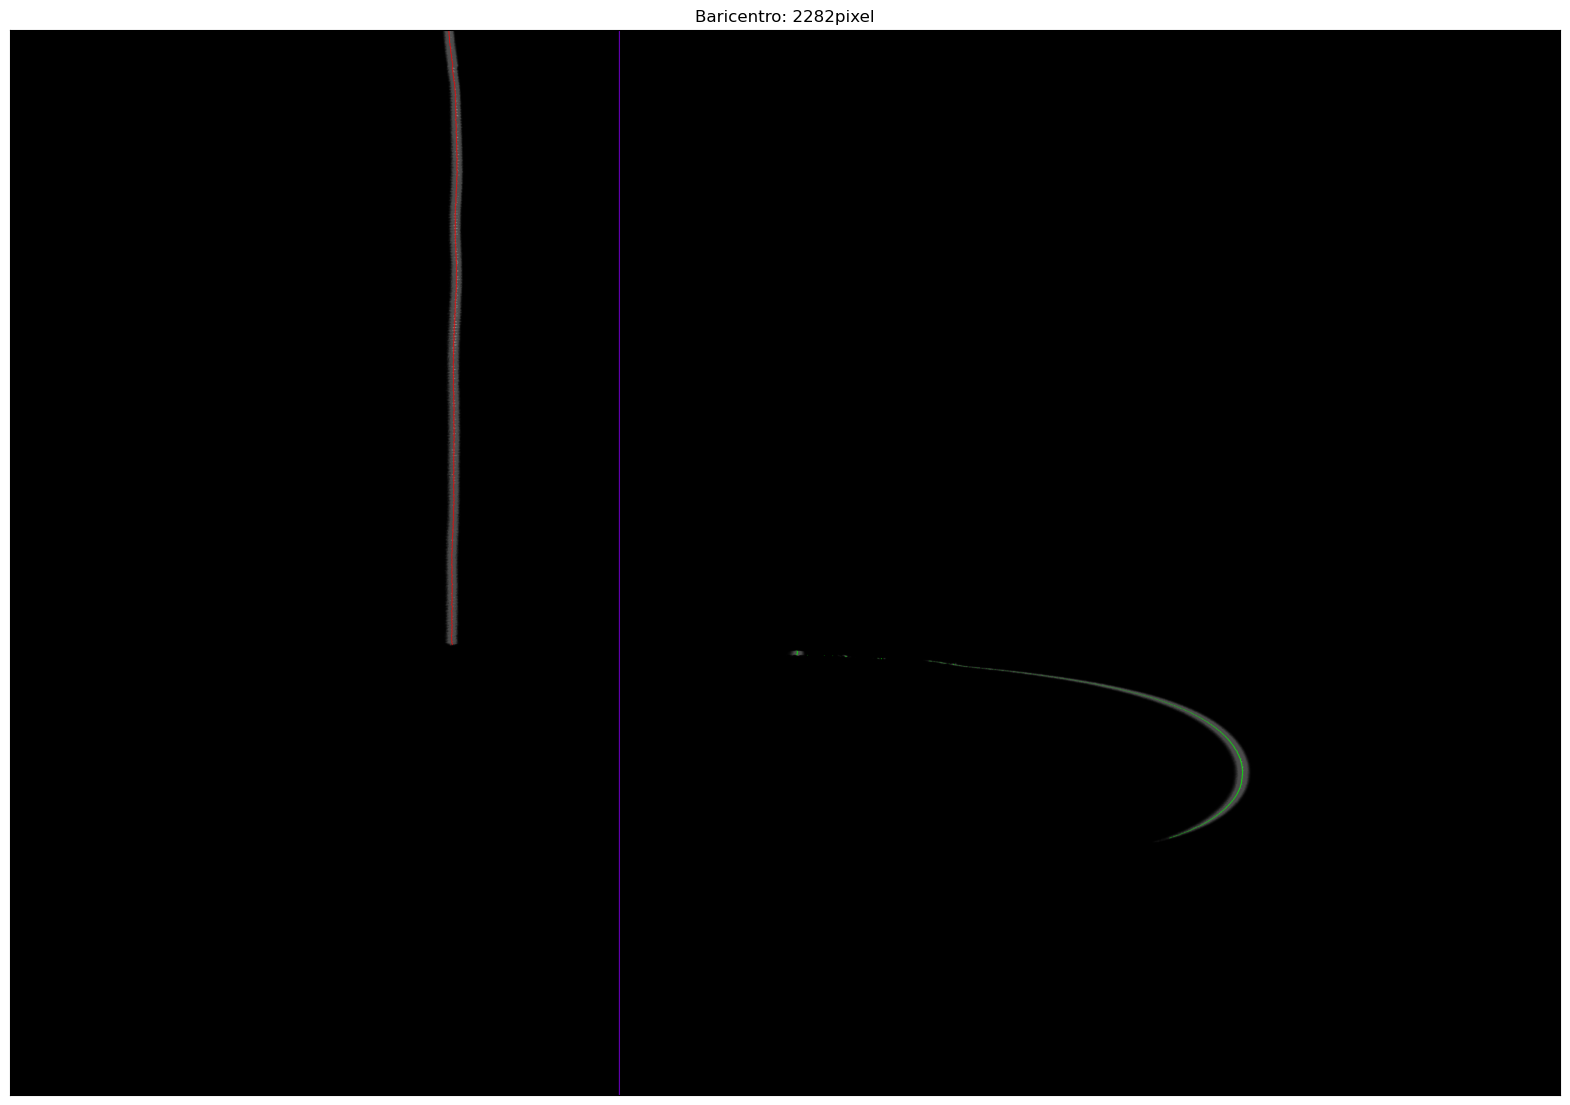

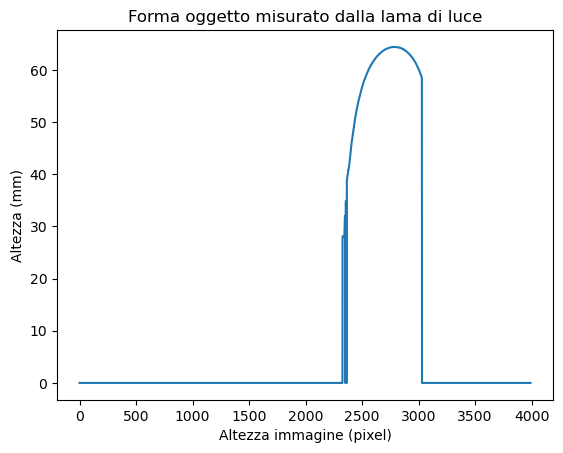

Altezza massima oggetto misurato: 64.44mm
Sensibilità del setup di misura: 0.0217mm
Portata del setup di misura: 125.78mm


In [16]:
img1 = cv.imread(os.path.join( IMGDIR, 'Misure_01.jpg'), cv.IMREAD_COLOR )
assert img1 is not None, "ERRORE: File non trovato!" 

# Identificazione dei baricentri della lama a z del piano riferimento e z dell'oggetto
bar_zRif1, bar_zOgg1, hIMG, binary, baricentri_np, pos_lama_media, wIMG = estrai_baricetri(img1) 

# Ricostruzione delle coordinate oggetto 3D dei baricentri identificati per ognuno dei 2 array
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(bar_zRif1)
x_ogg1, y_ogg1, z_ogg1 = estrai_punti_oggetto(bar_zOgg1)

# Calcolo della z media del piano di riferimeto
z_Rif_mean1 = np.mean(z_rif1)

# Calcolo della z massima raggiunta dal mio oggetto
z_Ogg_max1 = np.max(z_ogg1)

# Stampa dei risultati
formatted_z_Rif_mean1 = "{:.2f}".format(z_Rif_mean1)
formatted_z_Ogg_max1 = "{:.2f}".format(z_Ogg_max1)
print('\nz del piano di riferimento: ' + str(formatted_z_Rif_mean1)+' mm')
print('z massima dell\'oggetto: ' + str(formatted_z_Ogg_max1)+' mm')

risultato=[]
tempCont=0
        
for j in range(hIMG):
    if np.isnan(baricentri_np[j,1])==False:
        indice = int(baricentri_np[j,1])
        if indice>pos_lama_media:
            risultato.append((z_ogg1[tempCont] - z_Rif_mean1))
            tempCont+=1
        elif indice<pos_lama_media:
            risultato.append(0)
    else:
        risultato.append(0)


plt.figure()
plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Altezza immagine (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

d = z_Ogg_max1 - z_Rif_mean1  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
print('Portata del setup di misura: '+str(round(wIMG*sensibilita_setup,2)) + 'mm')

# 2- **CARICATORE iPhone**

#### Misura reale: 28 mm 
#### Piano a -20 mm
<img src="img\Misure_02.jpg" width="400">


z del piano di riferimento: -21.19 mm
z massima dell'oggetto: 6.86 mm


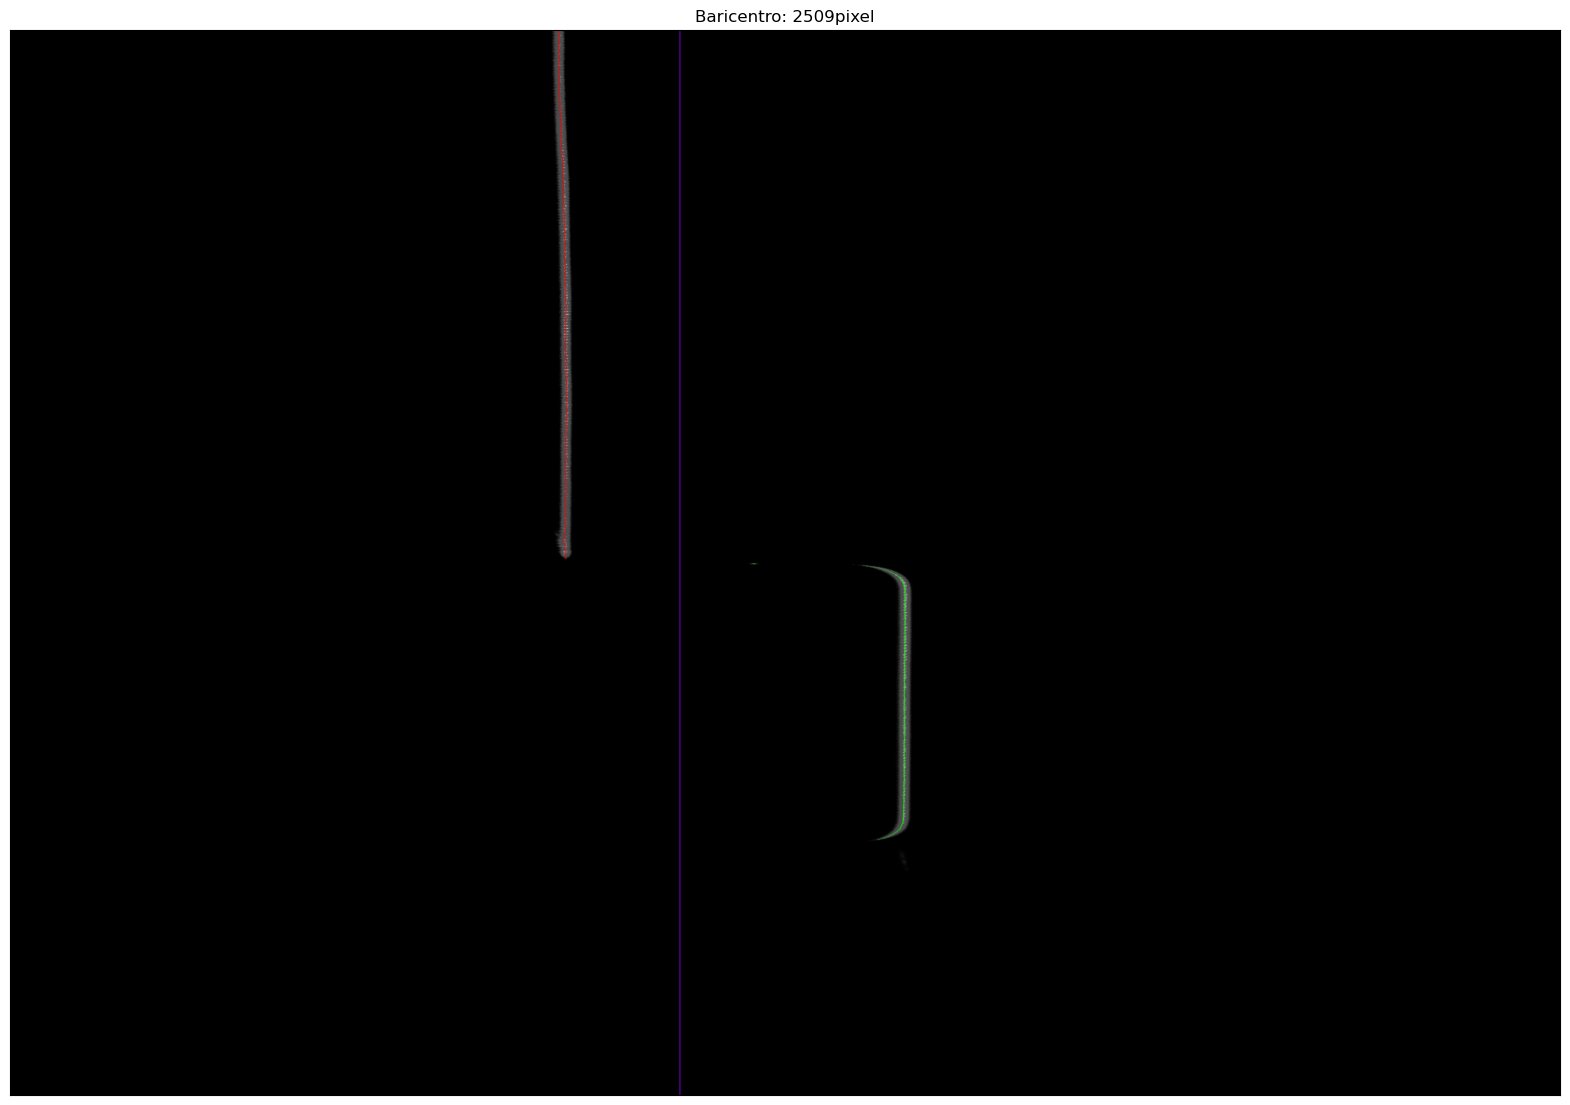

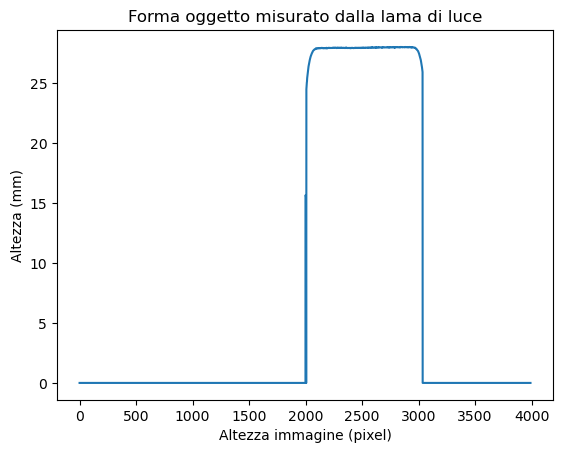

Altezza massima oggetto misurato: 28.04mm
Sensibilità del setup di misura: 0.0217mm
Portata del setup di misura: 125.78mm


In [17]:
img1 = cv.imread(os.path.join( IMGDIR, 'Misure_03.jpg'), cv.IMREAD_COLOR )
assert img1 is not None, "ERRORE: File non trovato!" 

# Identificazione dei baricentri della lama a z del piano riferimento e z dell'oggetto
bar_zRif1, bar_zOgg1, hIMG, binary, baricentri_np, pos_lama_media, wIMG = estrai_baricetri(img1) 

# Ricostruzione delle coordinate oggetto 3D dei baricentri identificati per ognuno dei 2 array
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(bar_zRif1)
x_ogg1, y_ogg1, z_ogg1 = estrai_punti_oggetto(bar_zOgg1)

# Calcolo della z media del piano di riferimeto
z_Rif_mean1 = np.mean(z_rif1)

# Calcolo della z massima raggiunta dal mio oggetto
z_Ogg_max1 = np.max(z_ogg1)

# Stampa dei risultati
formatted_z_Rif_mean1 = "{:.2f}".format(z_Rif_mean1)
formatted_z_Ogg_max1 = "{:.2f}".format(z_Ogg_max1)
print('\nz del piano di riferimento: ' + str(formatted_z_Rif_mean1)+' mm')
print('z massima dell\'oggetto: ' + str(formatted_z_Ogg_max1)+' mm')

risultato=[]
tempCont=0
        
for j in range(hIMG):
    if np.isnan(baricentri_np[j,1])==False:
        indice = int(baricentri_np[j,1])
        if indice>pos_lama_media:
            risultato.append((z_ogg1[tempCont] - z_Rif_mean1))
            tempCont+=1
        elif indice<pos_lama_media:
            risultato.append(0)
    else:
        risultato.append(0)


plt.figure()
plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Altezza immagine (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

d = z_Ogg_max1 - z_Rif_mean1  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
print('Portata del setup di misura: '+str(round(wIMG*sensibilita_setup,2)) + 'mm')

# 3- **SCOTCH**

#### Misura reale: 30 mm 
#### Piano a -20 mm
<img src="img\Misure_04.jpg" width="400">


z del piano di riferimento: -21.38 mm
z massima dell'oggetto: 8.89 mm


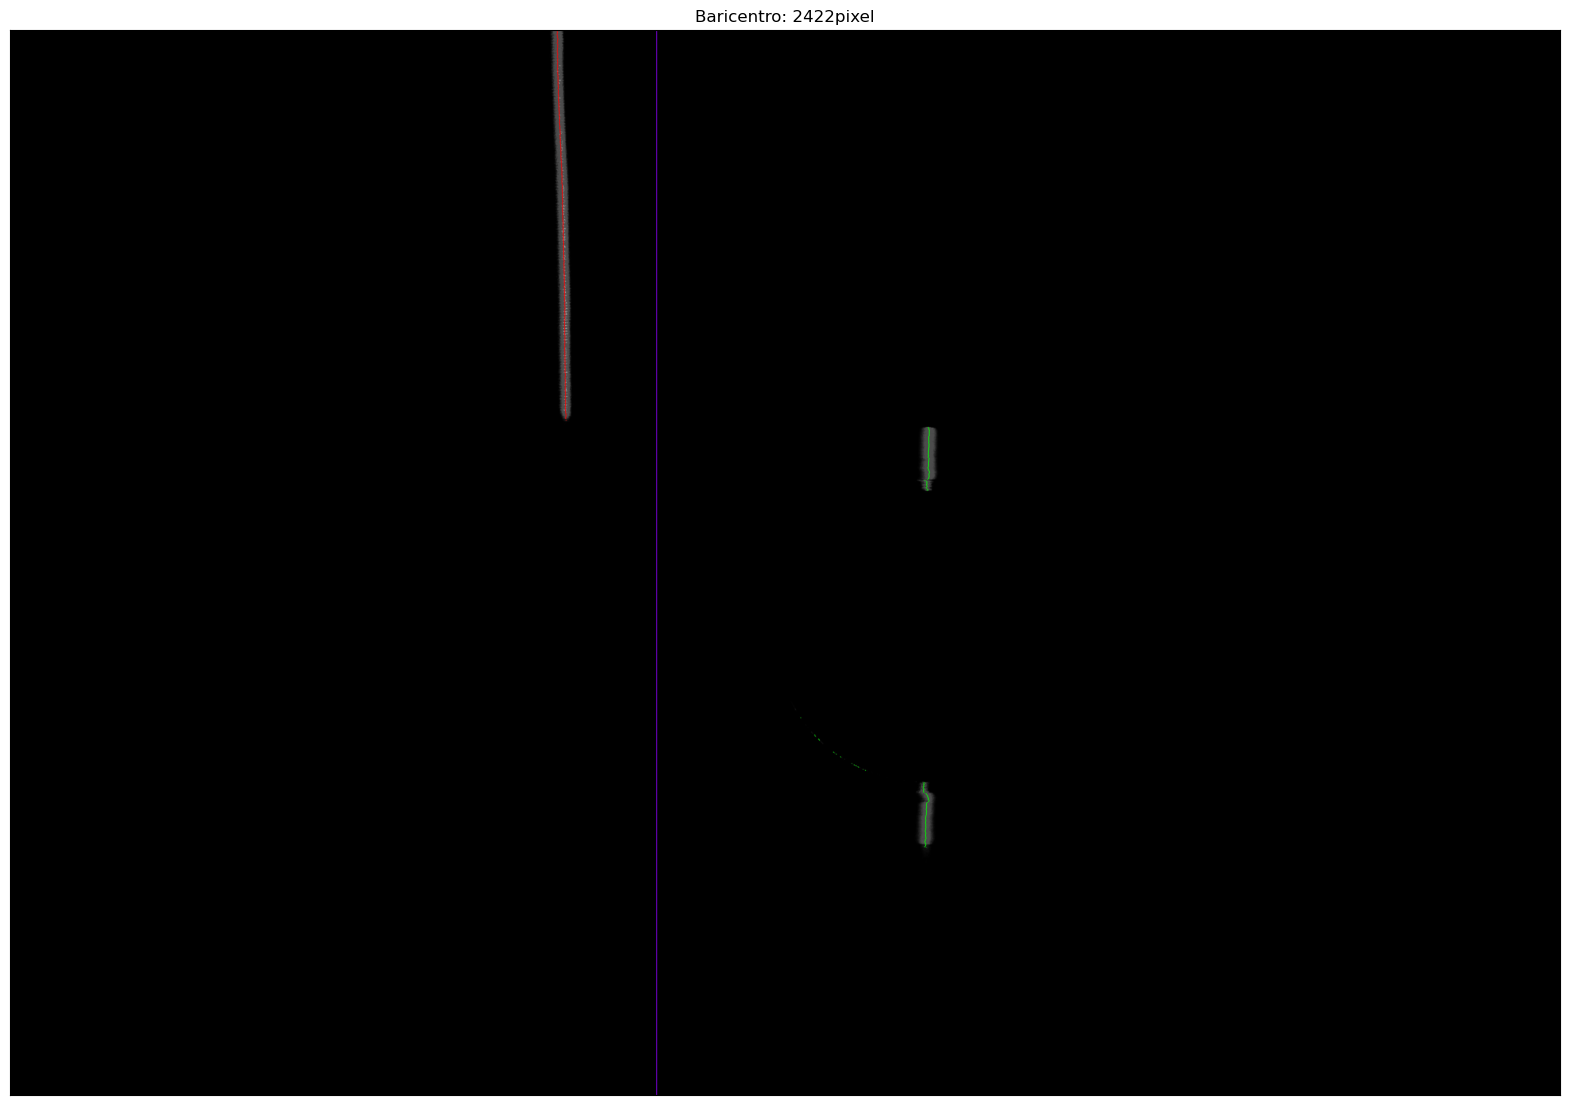

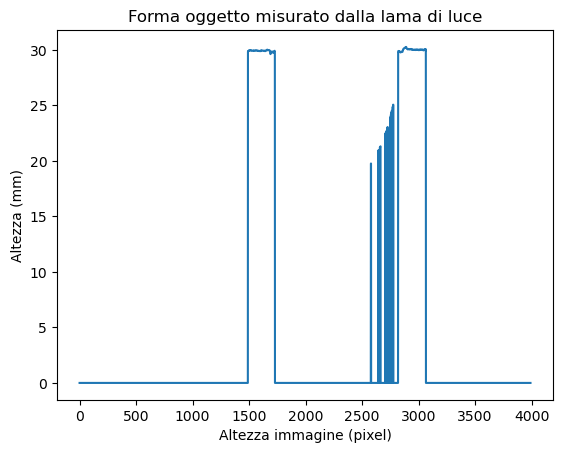

Altezza massima oggetto misurato: 30.26mm
Sensibilità del setup di misura: 0.0217mm
Portata del setup di misura: 125.78mm


In [18]:
img1 = cv.imread(os.path.join( IMGDIR, 'Misure_05.jpg'), cv.IMREAD_COLOR )
assert img1 is not None, "ERRORE: File non trovato!" 

# Identificazione dei baricentri della lama a z del piano riferimento e z dell'oggetto
bar_zRif1, bar_zOgg1, hIMG, binary, baricentri_np, pos_lama_media, wIMG = estrai_baricetri(img1) 

# Ricostruzione delle coordinate oggetto 3D dei baricentri identificati per ognuno dei 2 array
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(bar_zRif1)
x_ogg1, y_ogg1, z_ogg1 = estrai_punti_oggetto(bar_zOgg1)

# Calcolo della z media del piano di riferimeto
z_Rif_mean1 = np.mean(z_rif1)

# Calcolo della z massima raggiunta dal mio oggetto
z_Ogg_max1 = np.max(z_ogg1)

# Stampa dei risultati
formatted_z_Rif_mean1 = "{:.2f}".format(z_Rif_mean1)
formatted_z_Ogg_max1 = "{:.2f}".format(z_Ogg_max1)
print('\nz del piano di riferimento: ' + str(formatted_z_Rif_mean1)+' mm')
print('z massima dell\'oggetto: ' + str(formatted_z_Ogg_max1)+' mm')

risultato=[]
tempCont=0
        
for j in range(hIMG):
    if np.isnan(baricentri_np[j,1])==False:
        indice = int(baricentri_np[j,1])
        if indice>pos_lama_media:
            risultato.append((z_ogg1[tempCont] - z_Rif_mean1))
            tempCont+=1
        elif indice<pos_lama_media:
            risultato.append(0)
    else:
        risultato.append(0)


plt.figure()
plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Altezza immagine (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

d = z_Ogg_max1 - z_Rif_mean1  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
print('Portata del setup di misura: '+str(round(wIMG*sensibilita_setup,2)) + 'mm')

# 4- **BANCO NI 1**

#### Misura reale: 40 mm 
#### Piano a -30 mm
<img src="img\Misure_06.jpg" width="400">


z del piano di riferimento: -30.31 mm
z massima dell'oggetto: 10.12 mm


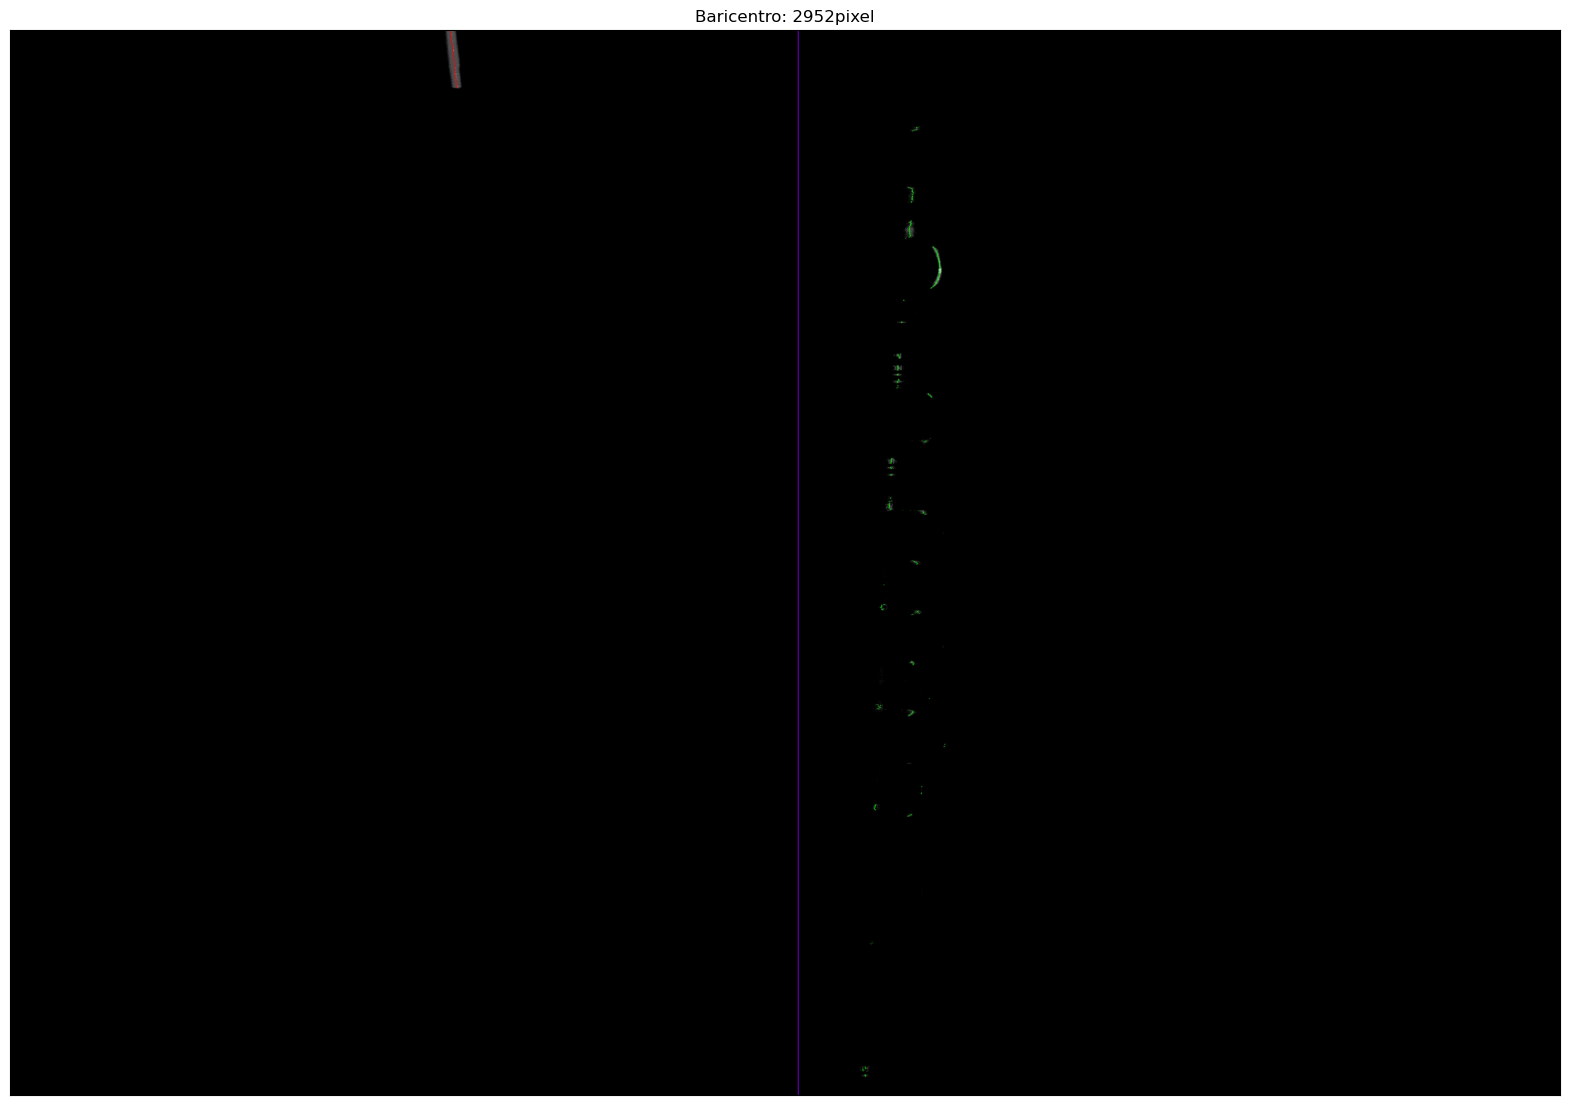

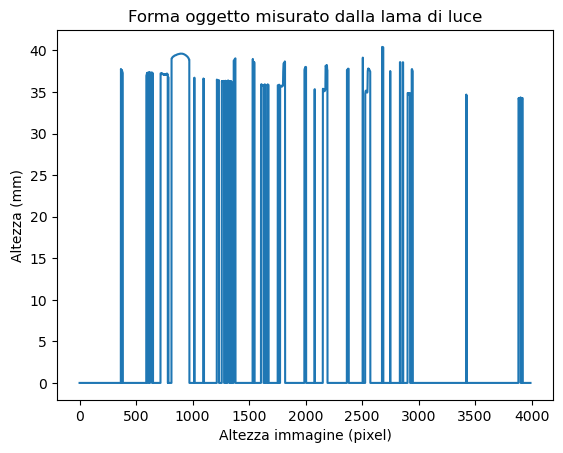

Altezza massima oggetto misurato: 40.42mm
Sensibilità del setup di misura: 0.0217mm
Portata del setup di misura: 125.78mm


In [19]:
img1 = cv.imread(os.path.join( IMGDIR, 'Misure_07.jpg'), cv.IMREAD_COLOR )
assert img1 is not None, "ERRORE: File non trovato!" 

# Identificazione dei baricentri della lama a z del piano riferimento e z dell'oggetto
bar_zRif1, bar_zOgg1, hIMG, binary, baricentri_np, pos_lama_media, wIMG = estrai_baricetri(img1) 

# Ricostruzione delle coordinate oggetto 3D dei baricentri identificati per ognuno dei 2 array
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(bar_zRif1)
x_ogg1, y_ogg1, z_ogg1 = estrai_punti_oggetto(bar_zOgg1)

# Calcolo della z media del piano di riferimeto
z_Rif_mean1 = np.mean(z_rif1)

# Calcolo della z massima raggiunta dal mio oggetto
z_Ogg_max1 = np.max(z_ogg1)

# Stampa dei risultati
formatted_z_Rif_mean1 = "{:.2f}".format(z_Rif_mean1)
formatted_z_Ogg_max1 = "{:.2f}".format(z_Ogg_max1)
print('\nz del piano di riferimento: ' + str(formatted_z_Rif_mean1)+' mm')
print('z massima dell\'oggetto: ' + str(formatted_z_Ogg_max1)+' mm')

risultato=[]
tempCont=0
        
for j in range(hIMG):
    if np.isnan(baricentri_np[j,1])==False:
        indice = int(baricentri_np[j,1])
        if indice>pos_lama_media:
            risultato.append((z_ogg1[tempCont] - z_Rif_mean1))
            tempCont+=1
        elif indice<pos_lama_media:
            risultato.append(0)
    else:
        risultato.append(0)


plt.figure()
plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Altezza immagine (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

d = z_Ogg_max1 - z_Rif_mean1  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
print('Portata del setup di misura: '+str(round(wIMG*sensibilita_setup,2)) + 'mm')

# 5- **BANCO NI 2**

#### Misura reale: 35 mm 
#### Piano a -30 mm
<img src="img\Misure_08.jpg" width="400">


z del piano di riferimento: -30.47 mm
z massima dell'oggetto: 5.67 mm


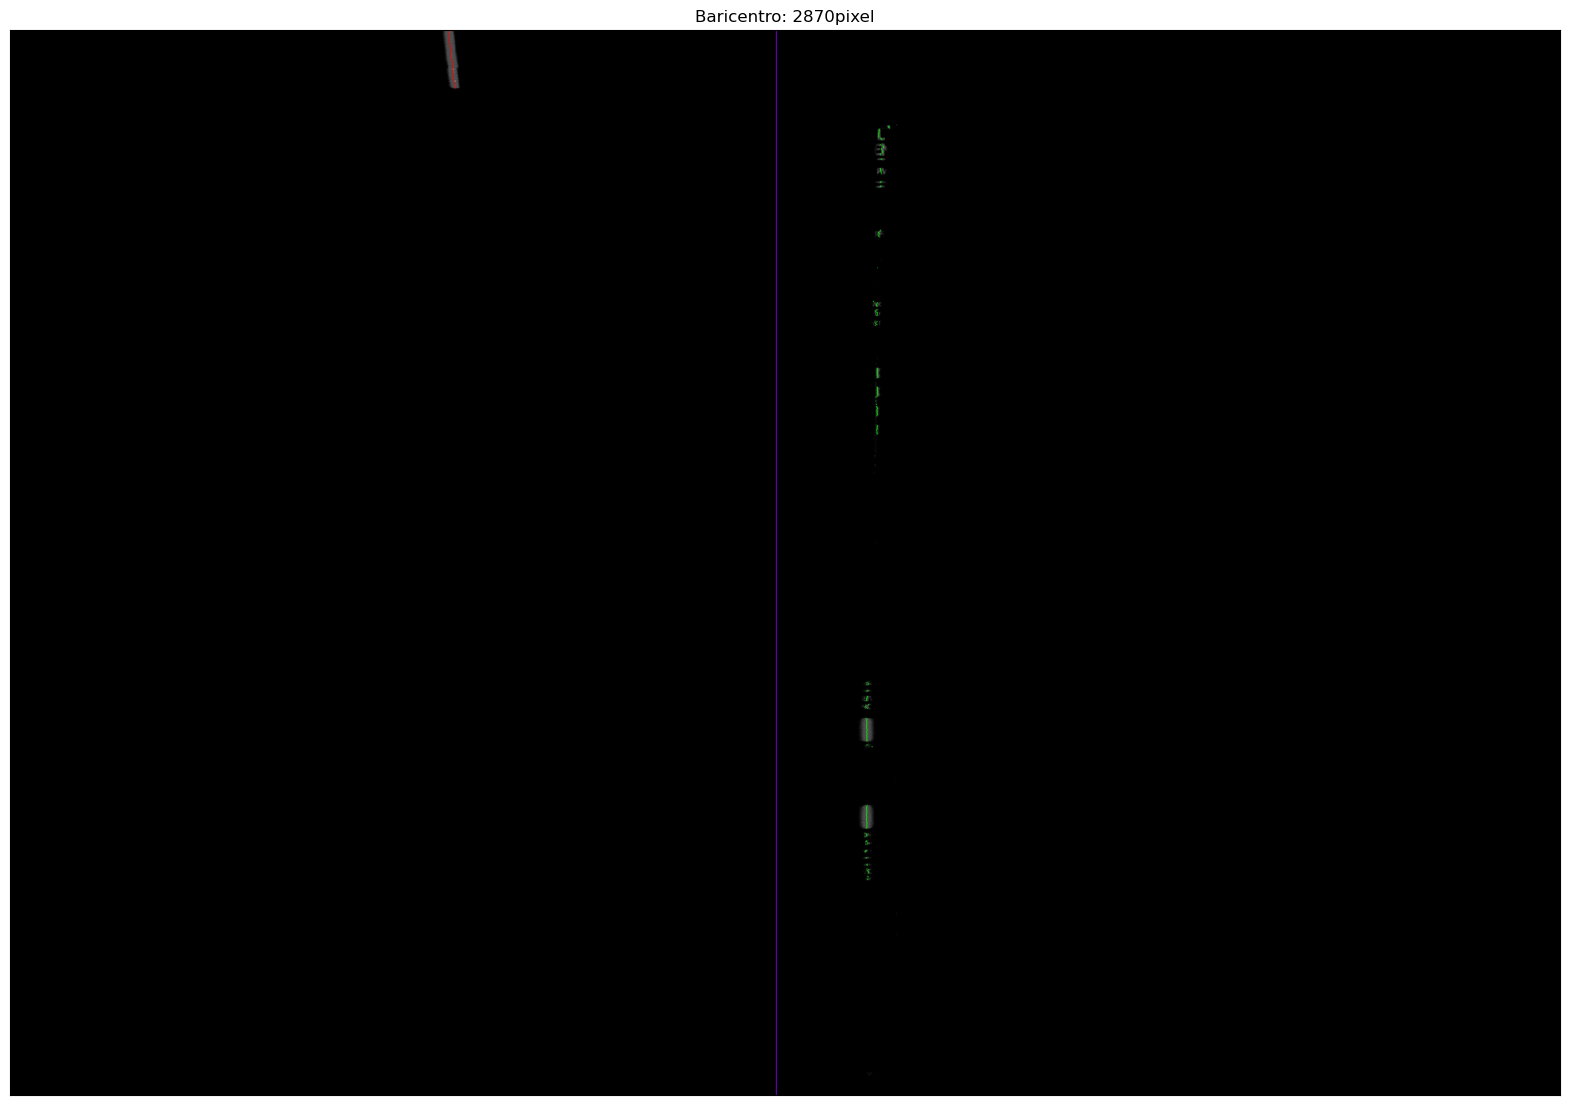

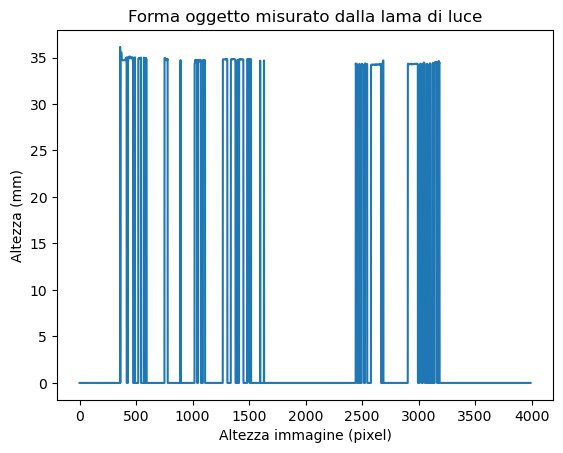

Altezza massima oggetto misurato: 36.14mm
Sensibilità del setup di misura: 0.0217mm
Portata del setup di misura: 125.78mm


In [20]:
img1 = cv.imread(os.path.join( IMGDIR, 'Misure_09.jpg'), cv.IMREAD_COLOR )
assert img1 is not None, "ERRORE: File non trovato!" 

# Identificazione dei baricentri della lama a z del piano riferimento e z dell'oggetto
bar_zRif1, bar_zOgg1, hIMG, binary, baricentri_np, pos_lama_media, wIMG = estrai_baricetri(img1) 

# Ricostruzione delle coordinate oggetto 3D dei baricentri identificati per ognuno dei 2 array
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(bar_zRif1)
x_ogg1, y_ogg1, z_ogg1 = estrai_punti_oggetto(bar_zOgg1)

# Calcolo della z media del piano di riferimeto
z_Rif_mean1 = np.mean(z_rif1)

# Calcolo della z massima raggiunta dal mio oggetto
z_Ogg_max1 = np.max(z_ogg1)

# Stampa dei risultati
formatted_z_Rif_mean1 = "{:.2f}".format(z_Rif_mean1)
formatted_z_Ogg_max1 = "{:.2f}".format(z_Ogg_max1)
print('\nz del piano di riferimento: ' + str(formatted_z_Rif_mean1)+' mm')
print('z massima dell\'oggetto: ' + str(formatted_z_Ogg_max1)+' mm')

risultato=[]
tempCont=0
        
for j in range(hIMG):
    if np.isnan(baricentri_np[j,1])==False:
        indice = int(baricentri_np[j,1])
        if indice>pos_lama_media:
            risultato.append((z_ogg1[tempCont] - z_Rif_mean1))
            tempCont+=1
        elif indice<pos_lama_media:
            risultato.append(0)
    else:
        risultato.append(0)


plt.figure()
plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Altezza immagine (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

d = z_Ogg_max1 - z_Rif_mean1  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
print('Portata del setup di misura: '+str(round(wIMG*sensibilita_setup,2)) + 'mm')